# Import necessary libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import sys
import os

# Add the parent directory's 'scripts' folder to the Python path
sys.path.append(os.path.abspath('../scripts'))

# Import the function
from class_metrics import display_metrics

# Load the the users with segments dataset

In [2]:
df = pd.read_csv('../data/cleaned/users_usage_segmented.csv')

In [3]:
sorted(df.columns)

['avg_data_after_upgrade',
 'avg_data_before_upgrade',
 'days_active_after',
 'increased_usage',
 'recharge_growth',
 'std_after',
 'std_before',
 'time_to_first_data_use',
 'total_recharge_after',
 'total_recharge_before',
 'user',
 'user_segment']

### we need to drop the columns that are not needed for the analysis

> 'avg_data_after_upgrade','days_active_after','std_after','time_to_first_data_use','user_segment', 'total_recharge_after',

so we only need the following columns

> 'avg_data_before_upgrade','increased_usage'(our target),'std_before','total_recharge_before','user',

In [4]:
df =  df[['user', 'avg_data_before_upgrade', 'std_before', 'total_recharge_before', 'increased_usage']]
df.sample(10)

,user,avg_data_before_upgrade,std_before,total_recharge_before,increased_usage
45,225798765478,4.305339,12.916016,2400.0,1
22,225798765455,NaN,NaN,NaN,0
49,225798765482,NaN,NaN,NaN,0
5,225798765437,NaN,NaN,NaN,0
54,225798765487,NaN,NaN,NaN,0
13,225798765445,NaN,NaN,NaN,0
4,225798765436,7.143986,32.579923,13800.0,1
31,225798765464,0.000000,NaN,100.0,0
8,225798765440,NaN,NaN,NaN,0
21,225798765454,NaN,NaN,NaN,0


Logistic, RandomForest or any other tree-based model from sklearn library don't support nan values and we have them

In [5]:
df.isna().sum()

user                        0
avg_data_before_upgrade    25
std_before                 34
total_recharge_before      25
increased_usage             0
dtype: int64

### Handle Missing values

we have missing values in 3 columns, we can't impute them bcs we might introduce false informations about users. 

**Solution:**

For each column with missing values let's create a binary label/flag indicating whether it's missing or not, then after let's fill nan with 0 which indicates we don't have values for that column

In [6]:
df['data_flag'] = df['avg_data_before_upgrade'].isna().astype(int)
df['std_flag'] = df['std_before'].isna().astype(int)
df['recharge_flag'] = df['total_recharge_before'].isna().astype(int)

# Fill missing values with 0

df['avg_data_before_upgrade'] = df['avg_data_before_upgrade'].fillna(0)
df['std_before'] = df['std_before'].fillna(0)
df['total_recharge_before'] = df['total_recharge_before'].fillna(0)

df.isna().sum()


user                       0
avg_data_before_upgrade    0
std_before                 0
total_recharge_before      0
increased_usage            0
data_flag                  0
std_flag                   0
recharge_flag              0
dtype: int64

In [7]:
df.to_csv('../data/cleaned/users_segmented_zero_nan.csv', index=False) 

# Train & Test split

In [8]:
X = df.drop(columns=['user', 'increased_usage'])
y = df['increased_usage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 ,shuffle=True)
X_train.shape

(45, 6)

# Baseline Model : RandomForest Classifier

Let's train & predict using a RandomForest regressor

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_scores = rf.predict_proba(X_test)[:, 1]

overfitness check

In [10]:
y_train_pred = rf.predict(X_train)
y_train_score = rf.predict_proba(X_train)[:, 1]

#### Baseline Metrics of the RandomForest model

In [11]:
print('************************Test metrics***********************')
display_metrics(y_true=y_test, y_pred=y_pred, y_scores=y_scores)

print('************************Train metrics***********************')
display_metrics(y_true=y_train, y_pred=y_train_pred , y_scores=y_train_score)

print('************************Feature importance***********************')
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

************************Test metrics***********************
Classification Metrics:
Precision: 1.0000
AUC-ROC: 0.8750
************************Train metrics***********************
Classification Metrics:
Precision: 1.0000
AUC-ROC: 1.0000
************************Feature importance***********************


,Feature,Importance
0,avg_data_before_upgrade,0.557369
1,std_before,0.174368
2,total_recharge_before,0.144223
3,data_flag,0.057102
5,recharge_flag,0.049357
4,std_flag,0.017580


# XGBoost model : training & predicting

In [12]:
xgb_class = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.3,
    random_state=42
)

xgb_class.fit(X_train, y_train)

y_pred_xgb = xgb_class.predict(X_test)
y_scores_xgb = xgb_class.predict_proba(X_test)[:, 1]

y_train_pred_xgb = xgb_class.predict(X_train)
y_train_score_xgb = xgb_class.predict_proba(X_train)[:, 1]

print('************************Test metrics***********************')
display_metrics(y_true=y_test, y_pred=y_pred_xgb, y_scores=y_scores_xgb)

print('************************Train metrics***********************')
display_metrics(y_true=y_train, y_pred=y_train_pred_xgb, y_scores=y_train_score_xgb)

print('************************Feature importance***********************')
importances_xgb = xgb_class.feature_importances_
feature_names_xgb = X.columns
feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names_xgb, 'Importance': importances_xgb})
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)
feature_importance_df_xgb

************************Test metrics***********************
Classification Metrics:
Precision: 1.0000
AUC-ROC: 0.9688
************************Train metrics***********************
Classification Metrics:
Precision: 1.0000
AUC-ROC: 1.0000
************************Feature importance***********************


,Feature,Importance
0,avg_data_before_upgrade,0.962263
2,total_recharge_before,0.037737
1,std_before,0.000000
3,data_flag,0.000000
4,std_flag,0.000000
5,recharge_flag,0.000000


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

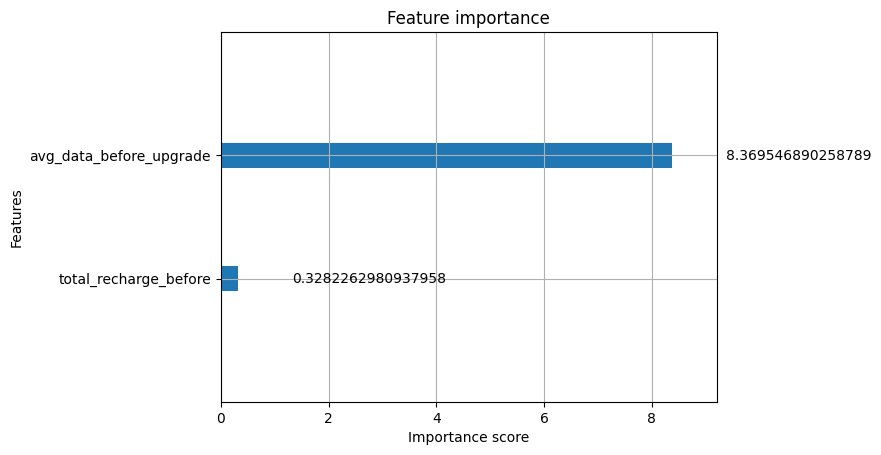

In [13]:
xgb.plot_importance(importance_type='gain', booster=xgb_class)

store new scores and predictions into a csv file

In [20]:
df_old = pd.read_csv('../data/cleaned/users_usage_segmented.csv')


df_old['xgb_score'] = xgb_class.predict_proba(X)[:, 1]
df_old['xgb_pred'] = xgb_class.predict(X)


df_old.to_csv('../data/cleaned/users_segmented_xgb_score.csv', index=False)

# Report

read the final report notebook found in the report directory